<a href="https://colab.research.google.com/github/m-wessler/gefs-ai-ml/blob/main/Consolidated_GEFS_ML_Max_Temp_Min_Temp_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUDA Available: False
PyTorch not available
Current Date and Time (UTC - YYYY-MM-DD HH:MM:SS formatted): 2025-06-18 15:37:57
Current User's Login: m-wessler
--------------------------------------------------
Starting ML Post-Processing Workflow
Model: XGBOOST
Stations: KBOI, KSLC, KSEA, KLAS
Forecast Hours: 024
--------------------------------------------------
Loading GEFS Reforecast data for 4 station(s) and 1 forecast hour(s)...
Multi-station mode or benchmark data: 'hgt_sfc' and 'elev_ft' will be included as features
  Loading file: /content/KBOI_2000_2009_f024.csv
  Successfully loaded 18265 rows
  Loading file: /content/KSLC_2000_2009_f024.csv
  Successfully loaded 18265 rows
  Loading file: /content/KSEA_2000_2009_f024.csv
  Successfully loaded 18265 rows
  Loading file: /content/KLAS_2000_2009_f024.csv
  Successfully loaded 18265 rows
Combined dataset: 73060 rows, 49 columns
Added day-of-year feature
Excluded 18 variables: ['sid', 'state', 'init_datetime', 'fcst_hour', 'perturb

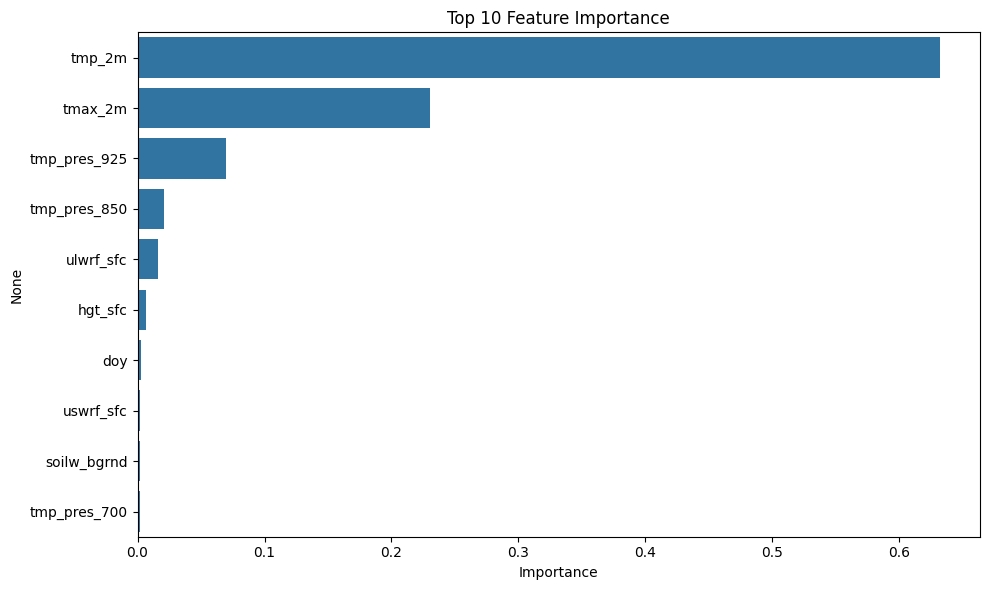

Found 365 common dates for comparison


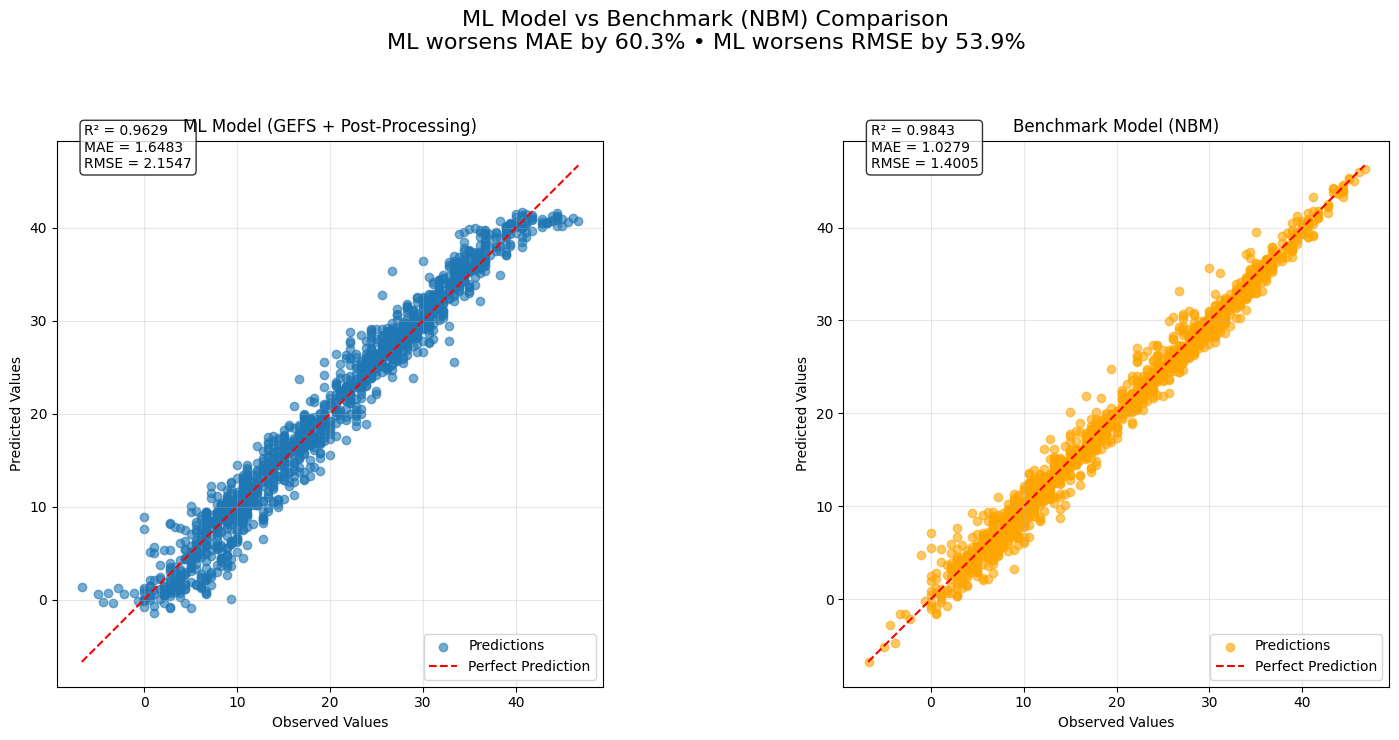

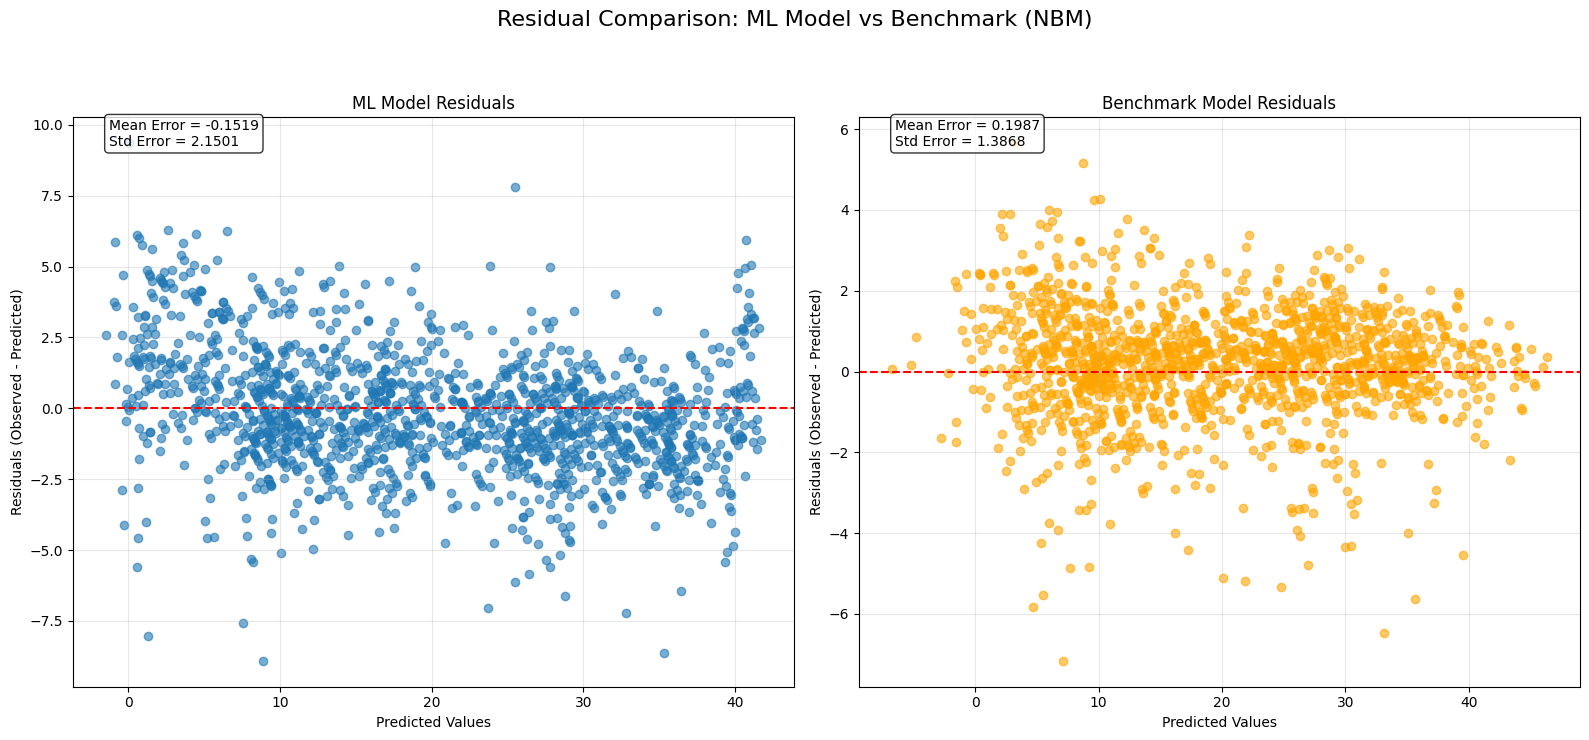

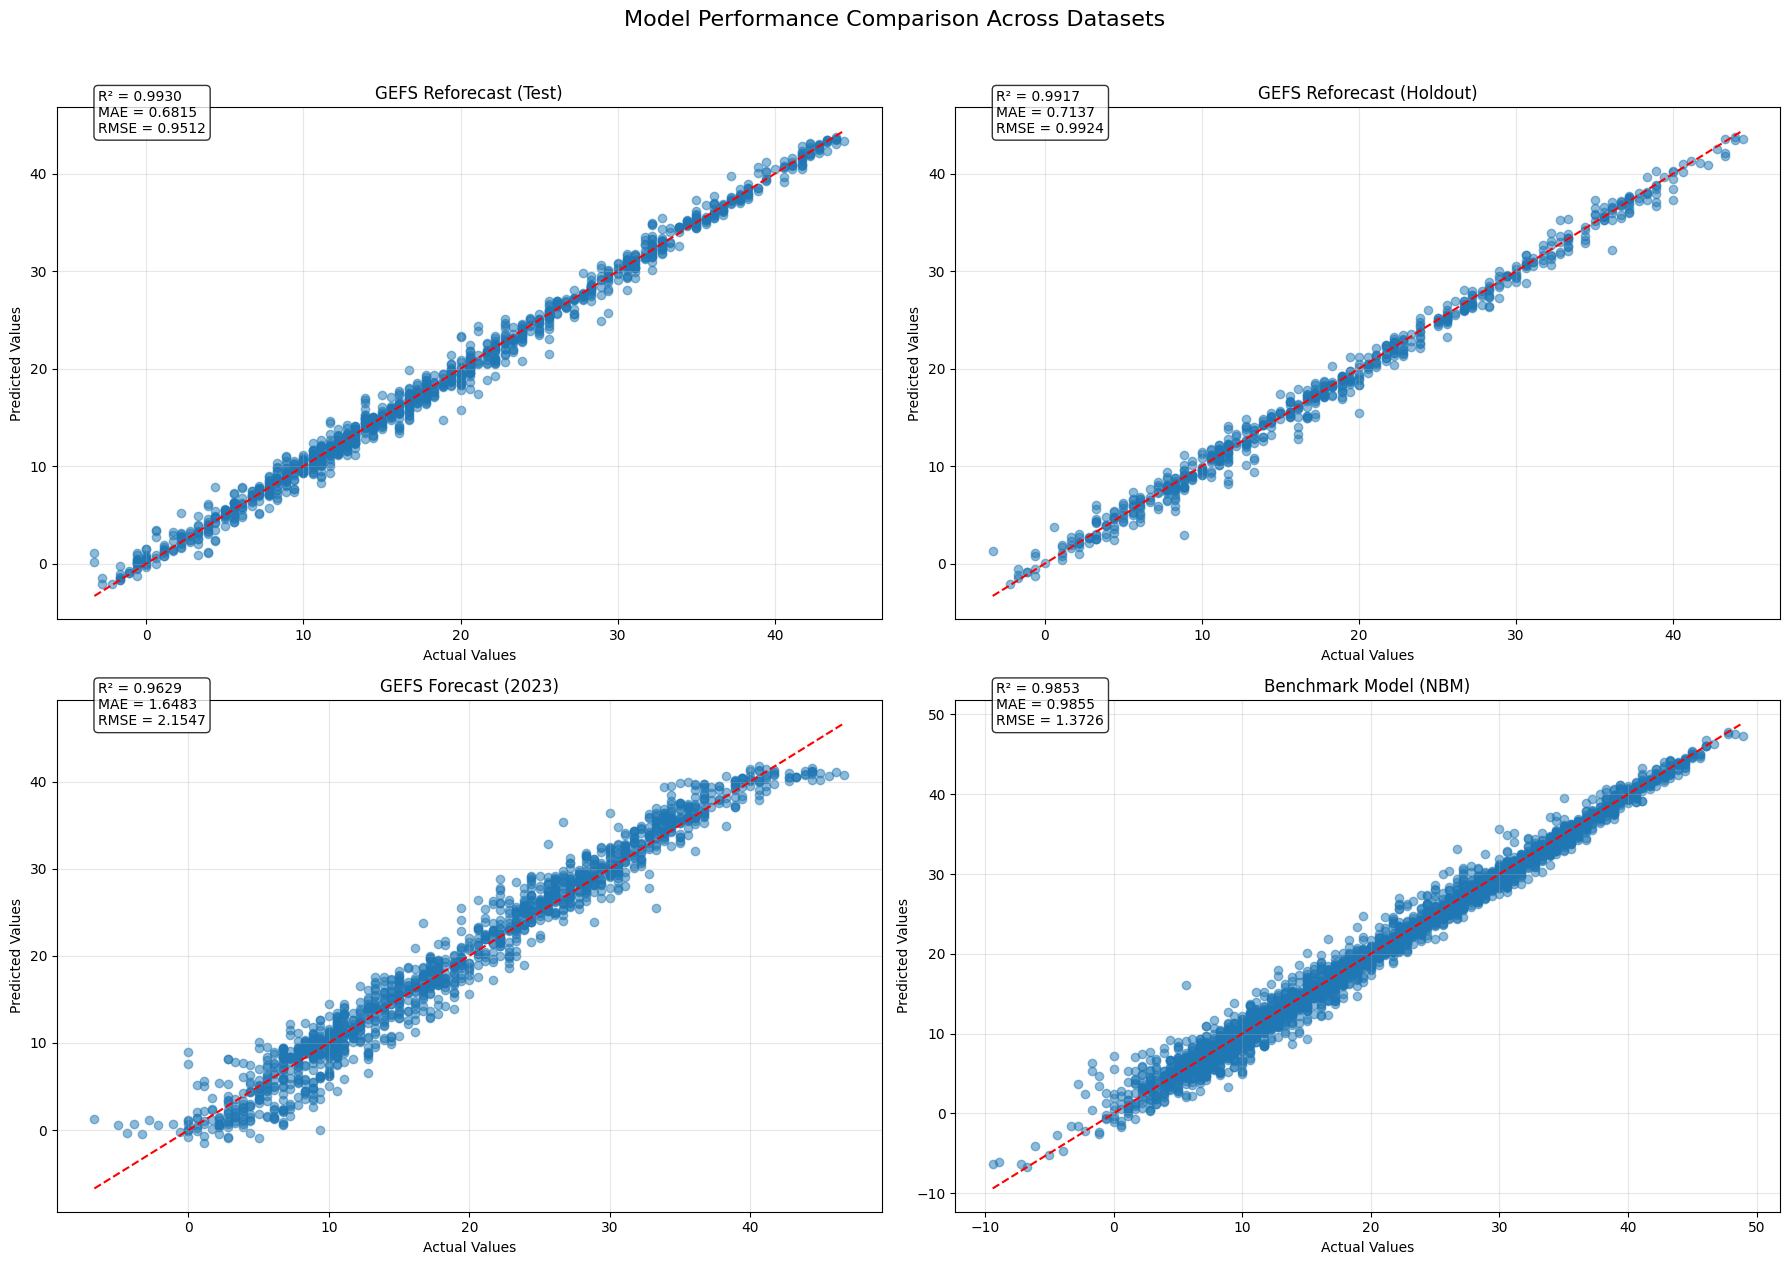

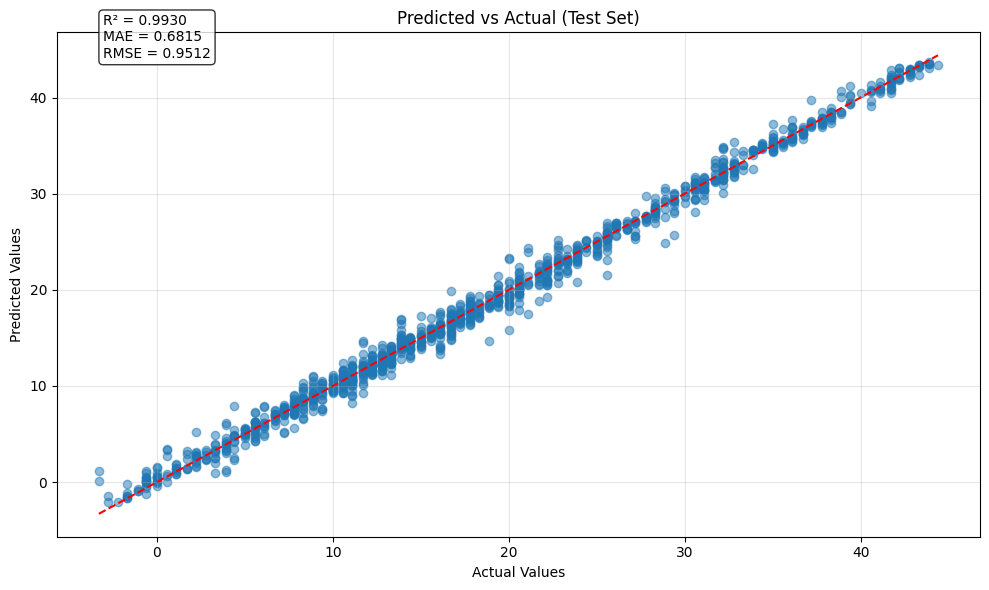

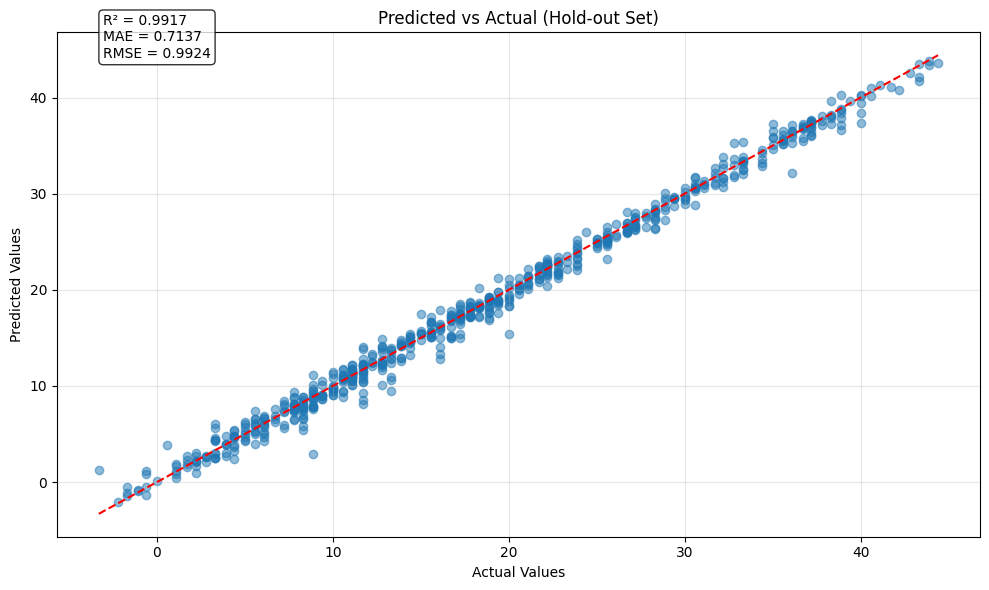

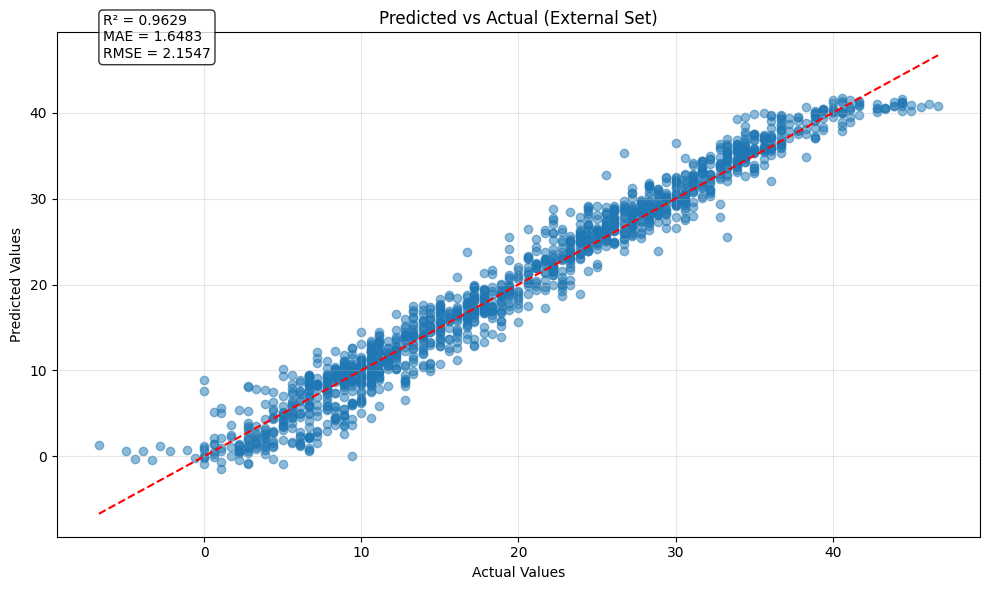

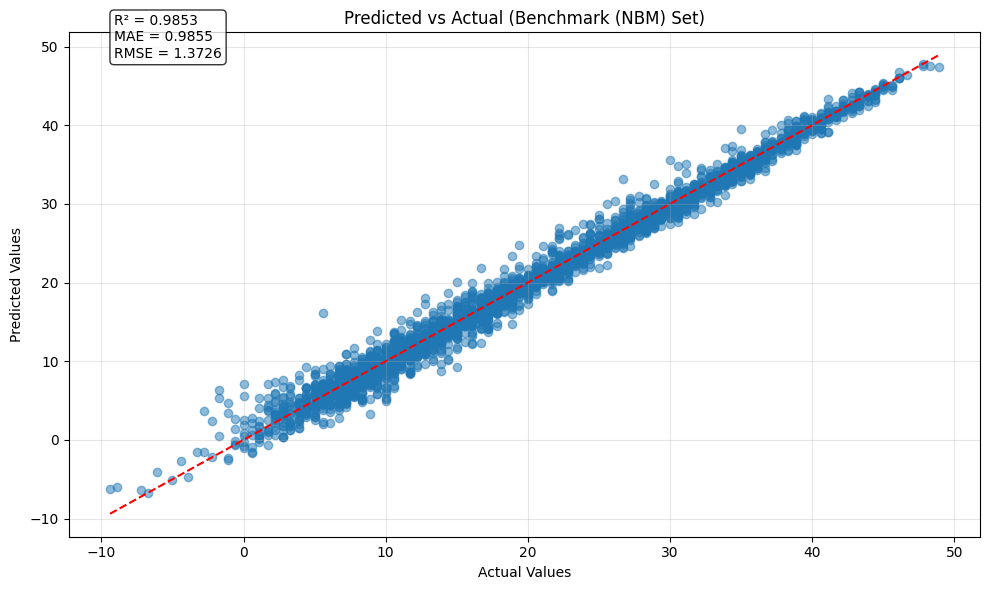

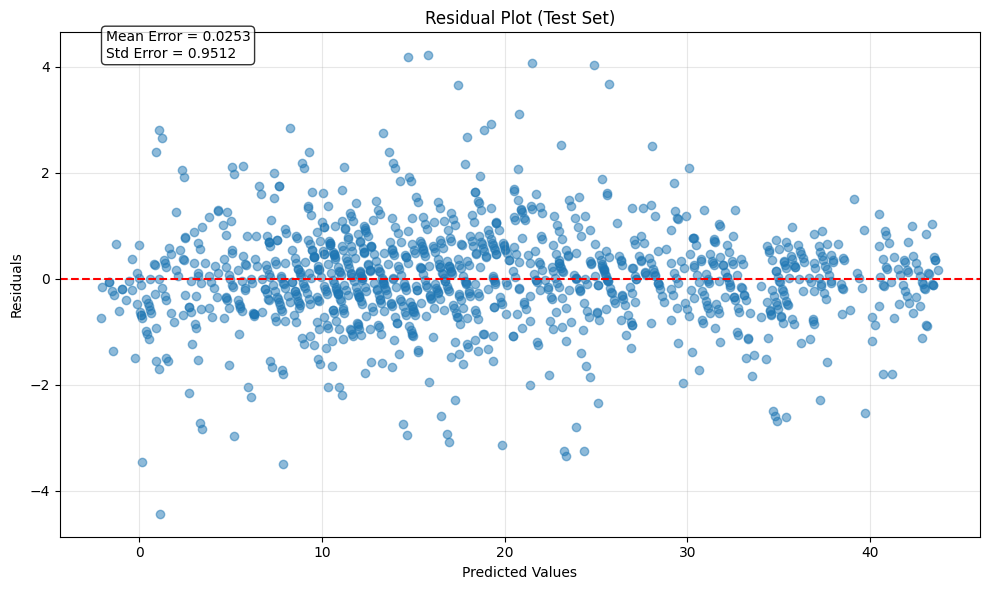

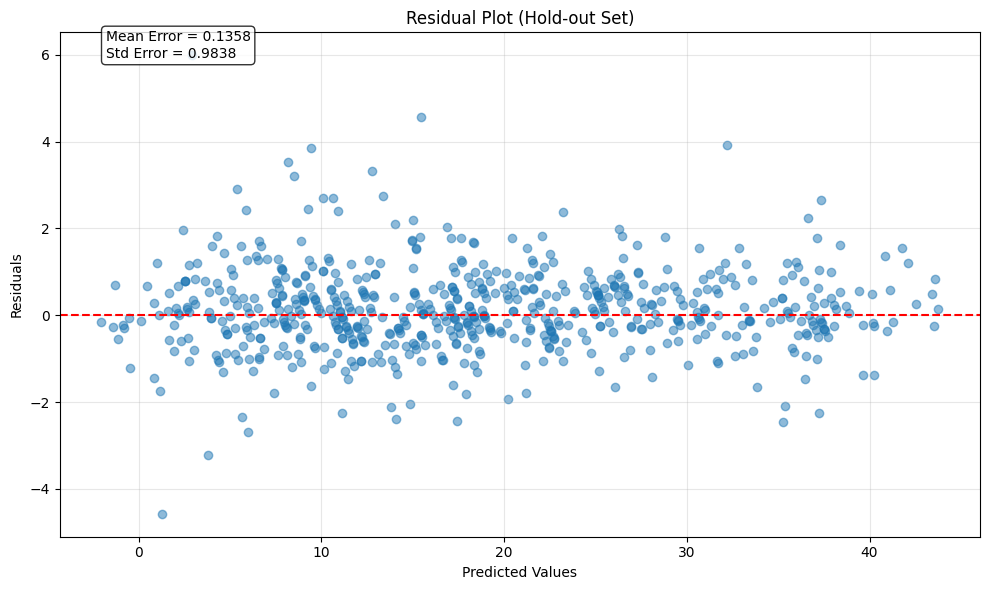

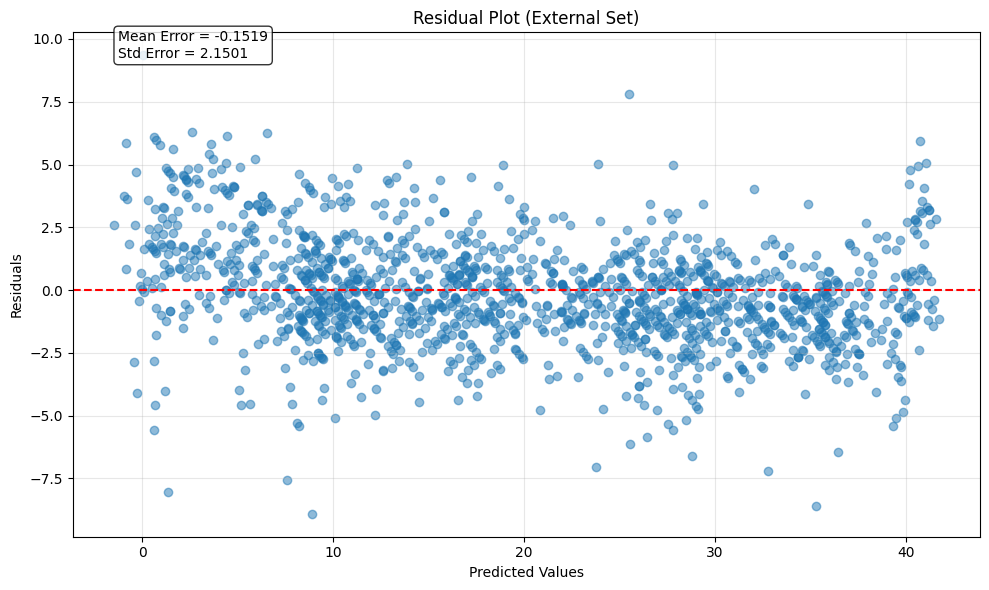

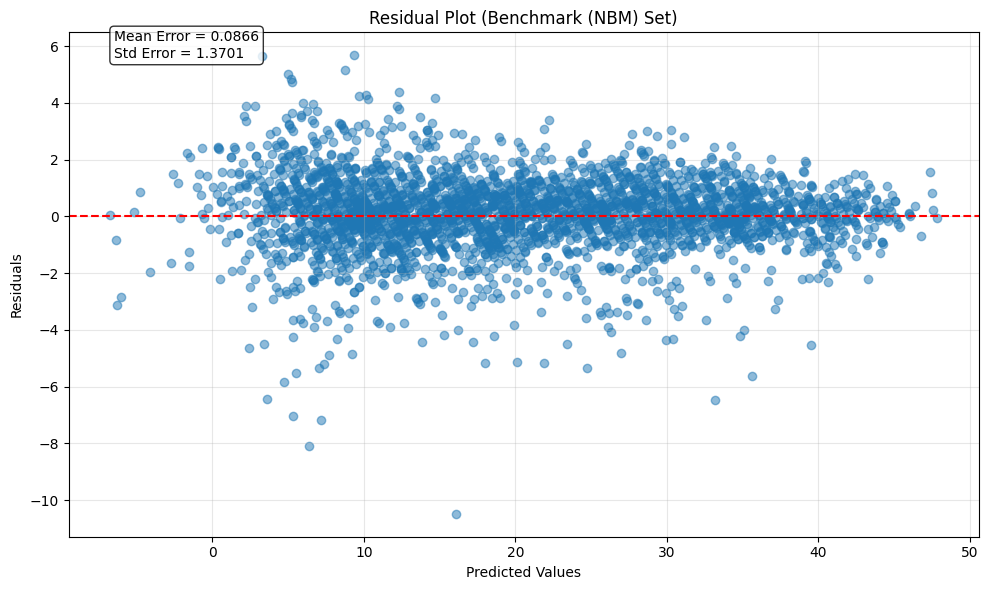

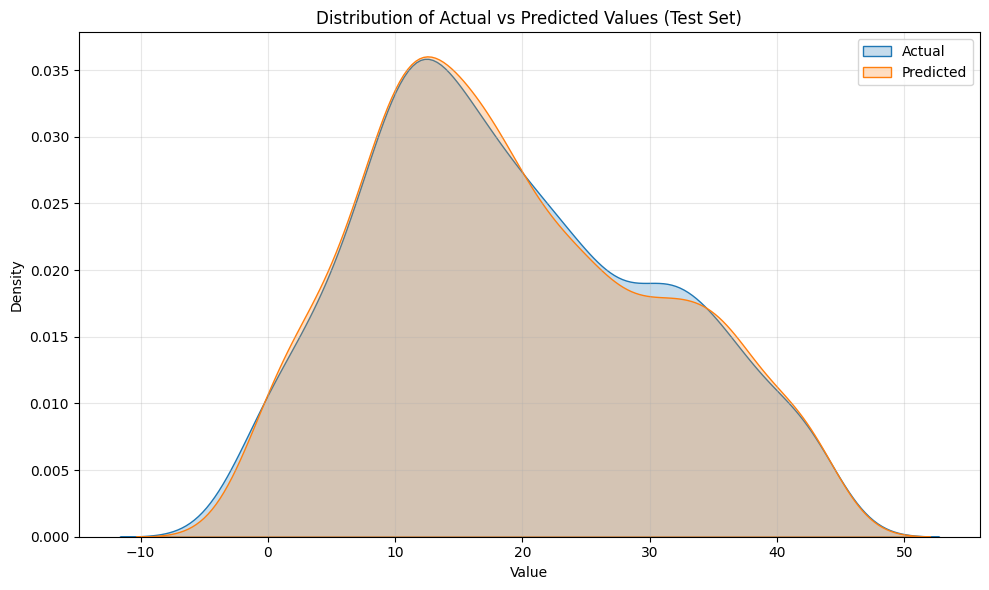

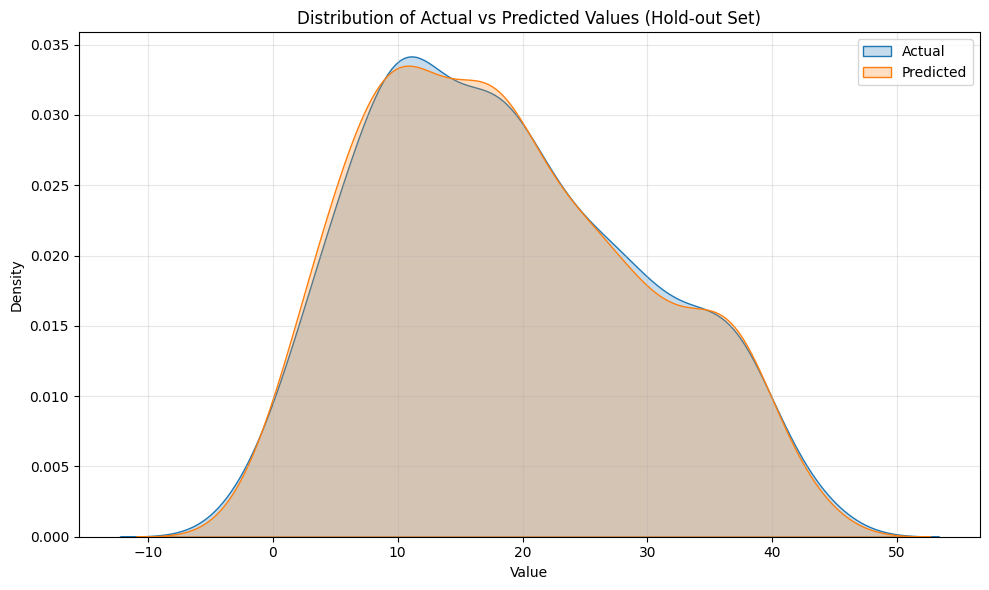

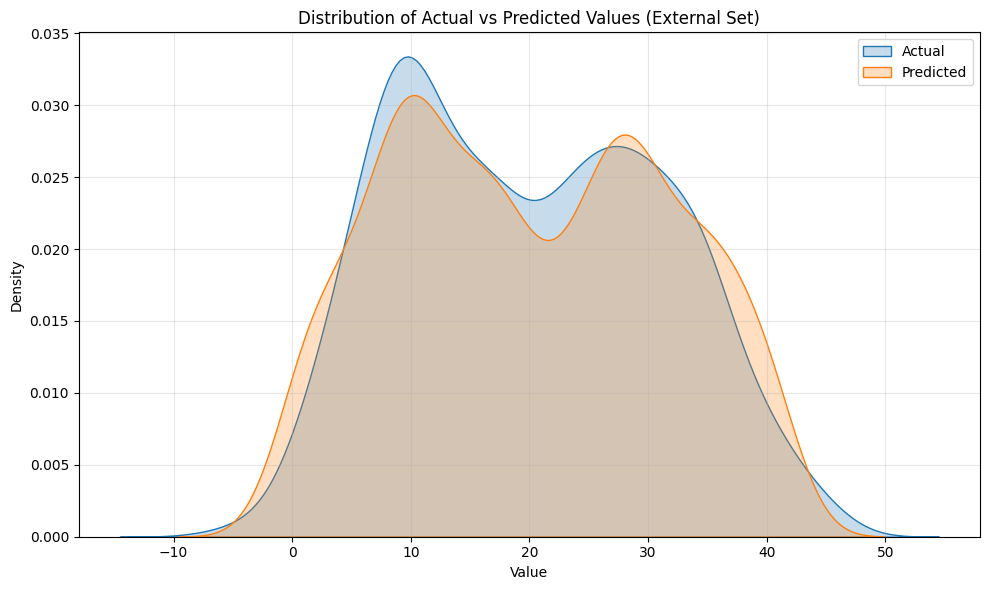

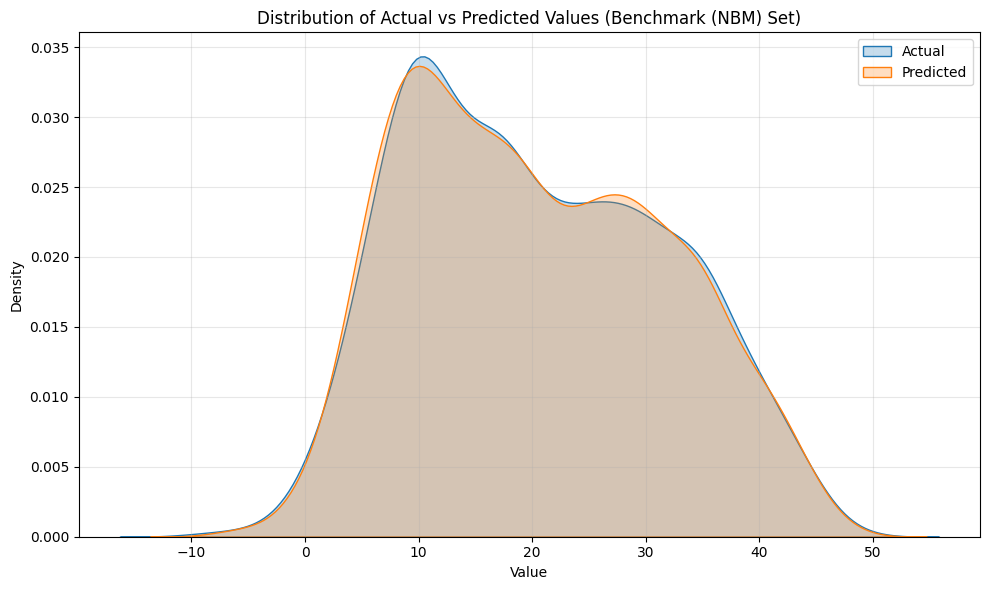

Error plotting feature importance: cannot reindex on an axis with duplicate labels

Workflow completed!


In [19]:
# Imports: Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import time
import glob
import warnings
warnings.filterwarnings('ignore')

# Imports: Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Import various model types
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgbm

# Optional: GPU Support Check
import torch
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    GPU = True
else:
    print("PyTorch not available")
    GPU = None

# Set random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Current timestamp for logging
print(f"Current Date and Time (UTC - YYYY-MM-DD HH:MM:SS formatted): 2025-06-18 15:37:57")
print(f"Current User's Login: m-wessler")
print("-" * 50)

# ==============================
# CONFIGURATION SECTION
# ==============================

# Data Configuration
CONFIG = {
    # Data Settings
    'data_dir': '/content/',                          # Directory containing the data files
    'station_ids': [],                          # List of station IDs to process
    'forecast_hours': [],                        # List of forecast hours to process
    'file_pattern': '{stid}_2000_2009_f{fhr}.csv',    # Pattern for filenames
    'target_variable': 'tmax_obs',                    # Target variable to predict

    # Cross-Model Evaluation Settings
    'external_data_enabled': True,                    # Enable cross-model evaluation
    'external_file_pattern': '{stid}_2023_2023_f{fhr}.csv',  # Pattern for external files

    # Benchmark Comparison Settings
    'benchmark_enabled': True,                        # Enable comparison with benchmark model
    'benchmark_file_pattern': '{stid}_2023_2024_f{fhr}.csv',  # Pattern for NBM benchmark files
    'benchmark_forecast_var': 'tmax_2m',              # Variable containing benchmark forecasts

    # Feature Selection Settings
    'base_exclude_vars': ['sid', 'state', 'init_datetime', 'fcst_hour',
                          'perturbation', 'tmin_obs', 'tmin_2m',

                          # Also exclude (for now) variables we haven't downloaded yet (bfile, sfile)
                          'spfh_pres_925', 'spfh_pres_850', 'spfh_pres_700', 'gflux_sfc',
                          'cape_sfc', 'hgt_ceiling', 'vflx_sfc', 'gust_sfc', 'cin_sfc',
                          'uflx_sfc', 'spfh_2m'
                          ],
    'numeric_only': True,                             # Filter to keep only numeric columns

    # Model Settings
    'model_type': 'xgboost',                          # Options: 'linear', 'ridge', 'lasso',
                                                      # 'elasticnet', 'rf', 'gbm', 'xgboost',
                                                      # 'lightgbm'
    'model_params': {                                 # Model-specific parameters
        'xgboost': {
            'n_estimators': 200,
            'learning_rate': 0.1,
            'max_depth': 6,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'tree_method': 'gpu_hist' if GPU else None,
            'random_state': RANDOM_STATE,
            'early_stopping_rounds':20,
        },
        'lightgbm': {
            'n_estimators': 200,
            'learning_rate': 0.1,
            'max_depth': 6,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': RANDOM_STATE
        },
        'rf': {
            'n_estimators': 200,
            'max_depth': 10,
            'min_samples_split': 5,
            'random_state': RANDOM_STATE
        },
        'linear': {},
        'ridge': {'alpha': 1.0},
        'lasso': {'alpha': 0.1},
        'elasticnet': {'alpha': 0.1, 'l1_ratio': 0.5},
        'gbm': {
            'n_estimators': 200,
            'learning_rate': 0.1,
            'max_depth': 6,
            'subsample': 0.8,
            'random_state': RANDOM_STATE
        },
    },

    # Training Settings
    'holdout_size': 0.1,                              # Proportion of data for hold-out verification
    'test_size': 0.2,                                 # Proportion of remaining data for testing
    'val_size': 0.2,                                  # Proportion of training data for validation
    'cv_folds': 5,                                    # Number of cross-validation folds

    # Preprocessing Settings
    'add_day_of_year': True,                          # Add day-of-year feature
    'standardize_features': False,                    # Standardize features
    'handle_missing': True,                           # Handle missing values

    # Visualization Settings
    'show_feature_importance': True,                  # Show feature importance plot
    'show_scatter_plot': True,                        # Show scatter plot of predictions
    'show_residual_plot': True,                       # Show residual plot
    'show_distribution_plot': True,                   # Show distribution of predictions vs actual
    'show_error_by_feature': True,                    # Show error distribution by key features
    'show_benchmark_comparison': True,                # Show comparison with benchmark model
    'top_n_features': 10,                             # Number of top features to display
    'show_cross_model_comparison': True               # Show comparison of model performance across datasets
}

# ==============================
# DATA LOADING & PREPROCESSING
# ==============================

def filter_numeric_columns(df, target_variable):
    """Filter dataframe to keep only numeric columns and the target variable"""
    # Ensure target variable is kept regardless of type
    all_columns = df.columns.tolist()
    non_target_columns = [col for col in all_columns if col != target_variable]

    # Select numeric columns from non-target columns
    numeric_columns = df[non_target_columns].select_dtypes(include=['number']).columns.tolist()

    # Add target variable back
    if target_variable in all_columns:
        columns_to_keep = numeric_columns + [target_variable]
    else:
        columns_to_keep = numeric_columns

    # Filter the dataframe
    df_numeric = df[columns_to_keep]

    # Report columns dropped
    dropped_columns = [col for col in all_columns if col not in columns_to_keep]
    if dropped_columns:
        print(f"Dropped {len(dropped_columns)} non-numeric columns: {dropped_columns}")

    return df_numeric

def load_data(config, file_pattern=None, is_external=False, is_benchmark=False):
    """Load and prepare the dataset based on configuration, handling multiple stations and forecast hours"""
    if is_benchmark:
        data_source = "NBM Benchmark"
    elif is_external:
        data_source = "External GEFS Forecast"
    else:
        data_source = "GEFS Reforecast"

    print(f"Loading {data_source} data for {len(config['station_ids'])} station(s) and {len(config['forecast_hours'])} forecast hour(s)...")

    # Use provided file pattern or default from config
    if file_pattern is None:
        file_pattern = config['file_pattern']

    # Determine if we're using single or multiple stations
    is_single_station = len(config['station_ids']) == 1

    # Define which variables to exclude based on station count
    exclude_vars = config['base_exclude_vars'].copy()

    # For single station, exclude elevation and surface height as they're constant
    if is_single_station and not is_benchmark:
        exclude_vars.extend(['hgt_sfc', 'elev_ft'])
        print("Single station mode: 'hgt_sfc' and 'elev_ft' will be excluded as features")
    else:
        print("Multi-station mode or benchmark data: 'hgt_sfc' and 'elev_ft' will be included as features")

    # Create list to hold all dataframes
    all_dfs = []

    # Loop through all combinations of station IDs and forecast hours
    for stid in config['station_ids']:
        for fhr in config['forecast_hours']:
            # Construct file path
            file_path = os.path.join(
                config['data_dir'],
                file_pattern.format(stid=stid, fhr=fhr)
            )

            print(f"  Loading file: {file_path}")

            # Check if file exists
            if not os.path.exists(file_path):
                print(f"  WARNING: File not found: {file_path}")
                continue

            # Load the CSV file
            try:
                df = pd.read_csv(file_path)

                # Add station and forecast hour as columns if multiple stations/hours
                if len(config['station_ids']) > 1:
                    df['station_id'] = stid
                if len(config['forecast_hours']) > 1:
                    df['forecast_hour'] = fhr

                all_dfs.append(df)
                print(f"  Successfully loaded {len(df)} rows")
            except Exception as e:
                print(f"  ERROR loading {file_path}: {str(e)}")

    # Concatenate all dataframes
    if not all_dfs:
        raise ValueError(f"No {data_source} data files were successfully loaded!")

    df = pd.concat(all_dfs, ignore_index=True)
    print(f"Combined dataset: {df.shape[0]} rows, {df.shape[1]} columns")

    # For single station, set constant values for hgt_sfc and elev_ft
    if is_single_station and not is_benchmark:
        if 'hgt_sfc' in df.columns:
            df['hgt_sfc'] = df['hgt_sfc'].iloc[0]
        if 'elev_ft' in df.columns:
            df['elev_ft'] = df['elev_ft'].iloc[0]

    # Convert datetime column if present
    if 'valid_datetime' in df.columns:
        df['valid_datetime'] = pd.to_datetime(df['valid_datetime'])

        # Add day of year if configured
        if config['add_day_of_year'] and not is_benchmark:
            df['doy'] = df['valid_datetime'].dt.dayofyear
            print("Added day-of-year feature")

        # Set datetime as index
        df.set_index('valid_datetime', inplace=True)

    # Handle excluding variables for both regular and benchmark data
    if exclude_vars:
        if is_benchmark:
            # For benchmark data, only keep the target and benchmark forecast variables
            keep_vars = [config['target_variable'], config['benchmark_forecast_var']]
            # Also keep any date/time columns that might be needed
            if 'valid_datetime' in df.columns and 'valid_datetime' not in keep_vars:
                keep_vars.append('valid_datetime')

            exclude_cols = [col for col in df.columns if col not in keep_vars]
            if exclude_cols:
                df = df.drop(columns=exclude_cols)
                print(f"Filtered benchmark data to keep only necessary variables: {keep_vars}")
        else:
            # For regular data, exclude the specified variables
            exclude_cols = [col for col in exclude_vars if col in df.columns]
            df = df.drop(columns=exclude_cols)
            print(f"Excluded {len(exclude_cols)} variables: {exclude_cols}")

    # Filter for numeric columns only if configured and not benchmark
    if config['numeric_only'] and not is_benchmark:
        original_col_count = df.shape[1]
        df = filter_numeric_columns(df, config['target_variable'])
        print(f"Filtered to {df.shape[1]} numeric columns from {original_col_count} total columns")

    # Handle missing values if configured
    if config['handle_missing']:
        original_rows = len(df)
        df.dropna(inplace=True)
        dropped_rows = original_rows - len(df)
        if dropped_rows > 0:
            print(f"Dropped {dropped_rows} rows with missing values ({dropped_rows/original_rows:.2%} of data)")

    print(f"Final {data_source} dataset shape: {df.shape}")
    return df

def prepare_data_splits(df, config):
    """Split data into features and target, with hold-out, train, validation, and test sets"""
    # Separate features and target
    X = df.drop(columns=[config['target_variable']])
    y = df[config['target_variable']]

    # First split to separate hold-out data (10% of all data)
    X_main, X_holdout, y_main, y_holdout = train_test_split(
        X, y,
        test_size=config['holdout_size'],
        random_state=RANDOM_STATE
    )

    # Second split for test set (20% of main data)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_main, y_main,
        test_size=config['test_size'],
        random_state=RANDOM_STATE
    )

    # Third split for validation set (20% of temp data)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=config['val_size'],
        random_state=RANDOM_STATE
    )

    print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(df):.1%} of data)")
    print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(df):.1%} of data)")
    print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(df):.1%} of data)")
    print(f"Hold-out set: {X_holdout.shape[0]} samples ({X_holdout.shape[0]/len(df):.1%} of data)")

    return X_train, X_val, X_test, X_holdout, y_train, y_val, y_test, y_holdout

def load_external_data(config):
    """Load and prepare external data for cross-model evaluation"""
    if not config['external_data_enabled']:
        print("Cross-model evaluation is disabled in configuration")
        return None, None

    # Load external data using the same process as training data
    external_df = load_data(config, config['external_file_pattern'], is_external=True)

    # Separate features and target
    if config['target_variable'] in external_df.columns:
        X_external = external_df.drop(columns=[config['target_variable']])
        y_external = external_df[config['target_variable']]
        print(f"External dataset contains the target variable '{config['target_variable']}'")
    else:
        X_external = external_df
        y_external = None
        print(f"Warning: External dataset does not contain the target variable '{config['target_variable']}'")

    return X_external, y_external

def load_benchmark_data(config):
    """Load and prepare benchmark model data (NBM) for comparison"""
    if not config['benchmark_enabled']:
        print("Benchmark comparison is disabled in configuration")
        return None

    # Load benchmark data
    benchmark_df = load_data(config, config['benchmark_file_pattern'], is_benchmark=True)

    # Check if required columns exist
    required_cols = [config['target_variable'], config['benchmark_forecast_var']]
    missing_cols = [col for col in required_cols if col not in benchmark_df.columns]

    if missing_cols:
        print(f"Warning: Benchmark data missing required columns: {missing_cols}")
        return None

    print(f"Successfully loaded benchmark data with {len(benchmark_df)} rows")
    return benchmark_df

# ==============================
# MODEL DEFINITION & TRAINING
# ==============================

def get_model(config):
    """Initialize model based on configuration"""
    model_type = config['model_type'].lower()
    model_params = config['model_params'].get(model_type, {})

    if model_type == 'linear':
        return LinearRegression(**model_params)
    elif model_type == 'ridge':
        return Ridge(**model_params)
    elif model_type == 'lasso':
        return Lasso(**model_params)
    elif model_type == 'elasticnet':
        return ElasticNet(**model_params)
    elif model_type == 'rf':
        return RandomForestRegressor(**model_params)
    elif model_type == 'gbm':
        return GradientBoostingRegressor(**model_params)
    elif model_type == 'xgboost':
        return XGBRegressor(**model_params)
    elif model_type == 'lightgbm':
        return lgbm.LGBMRegressor(**model_params)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

def create_pipeline(config, model):
    """Create a pipeline with preprocessing steps and model"""
    steps = []

    # Add preprocessing steps if configured
    if config['standardize_features']:
        steps.append(('scaler', StandardScaler()))

    # Add the model
    steps.append(('model', model))

    return Pipeline(steps)

def train_model(pipeline, X_train, y_train, X_val, y_val, config):
    """Train the model with early stopping if supported"""
    model_type = config['model_type'].lower()
    model = pipeline.named_steps['model']

    start_time = time.time()
    print(f"Training {model_type.upper()} model...")

    # Handle models that support early stopping
    if model_type in ['xgboost', 'lightgbm']:
        if model_type == 'xgboost':
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
        elif model_type == 'lightgbm':
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                early_stopping_rounds=20,
                verbose=False
            )
    else:
        # For models without early stopping
        pipeline.fit(X_train, y_train)

    training_time = time.time() - start_time
    print(f"Model training completed in {training_time:.2f} seconds")

    return pipeline

def evaluate_model(pipeline, X_train, y_train, X_val, y_val, X_test, y_test):
    """Evaluate model on training, validation, and test sets"""
    results = {}

    # Evaluate on training set
    y_train_pred = pipeline.predict(X_train)
    results['train'] = {
        'r2': r2_score(y_train, y_train_pred),
        'mae': mean_absolute_error(y_train, y_train_pred),
        'rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'actual': y_train,
        'predicted': pd.Series(y_train_pred, index=y_train.index)  # Convert to Series with same index
    }

    # Evaluate on validation set
    y_val_pred = pipeline.predict(X_val)
    results['val'] = {
        'r2': r2_score(y_val, y_val_pred),
        'mae': mean_absolute_error(y_val, y_val_pred),
        'rmse': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'actual': y_val,
        'predicted': pd.Series(y_val_pred, index=y_val.index)  # Convert to Series with same index
    }

    # Evaluate on test set
    y_test_pred = pipeline.predict(X_test)
    results['test'] = {
        'r2': r2_score(y_test, y_test_pred),
        'mae': mean_absolute_error(y_test, y_test_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'actual': y_test,
        'predicted': pd.Series(y_test_pred, index=y_test.index)  # Convert to Series with same index
    }

    # Print results
    print("\nModel Evaluation Results:")
    print(f"{'Dataset':<10} {'R²':<10} {'MAE':<10} {'RMSE':<10}")
    print("-" * 40)
    for dataset, metrics in results.items():
        print(f"{dataset:<10} {metrics['r2']:<10.4f} {metrics['mae']:<10.4f} {metrics['rmse']:<10.4f}")

    return results

def evaluate_holdout(pipeline, X_holdout, y_holdout):
    """Evaluate model on hold-out verification dataset"""
    # Predict on hold-out set
    y_holdout_pred = pipeline.predict(X_holdout)

    # Calculate metrics
    holdout_results = {
        'holdout': {
            'r2': r2_score(y_holdout, y_holdout_pred),
            'mae': mean_absolute_error(y_holdout, y_holdout_pred),
            'rmse': np.sqrt(mean_squared_error(y_holdout, y_holdout_pred)),
            'actual': y_holdout,
            'predicted': pd.Series(y_holdout_pred, index=y_holdout.index)  # Convert to Series with same index
        }
    }

    # Print results
    print("\nHold-out Verification Results:")
    print(f"{'Dataset':<10} {'R²':<10} {'MAE':<10} {'RMSE':<10}")
    print("-" * 40)
    print(f"{'holdout':<10} {holdout_results['holdout']['r2']:<10.4f} "
          f"{holdout_results['holdout']['mae']:<10.4f} "
          f"{holdout_results['holdout']['rmse']:<10.4f}")

    return holdout_results

def evaluate_external(pipeline, X_external, y_external=None):
    """Evaluate model on external data (different model)"""
    # Make predictions on external data
    y_external_pred = pipeline.predict(X_external)

    # If we have actual values, calculate metrics
    external_results = {
        'external': {
            'predicted': pd.Series(y_external_pred, index=X_external.index)  # Convert to Series with same index
        }
    }

    if y_external is not None:
        external_results['external'].update({
            'r2': r2_score(y_external, y_external_pred),
            'mae': mean_absolute_error(y_external, y_external_pred),
            'rmse': np.sqrt(mean_squared_error(y_external, y_external_pred)),
            'actual': y_external
        })

        # Print results
        print("\nExternal Data Evaluation Results (GEFS Forecast):")
        print(f"{'Dataset':<10} {'R²':<10} {'MAE':<10} {'RMSE':<10}")
        print("-" * 40)
        print(f"{'external':<10} {external_results['external']['r2']:<10.4f} "
              f"{external_results['external']['mae']:<10.4f} "
              f"{external_results['external']['rmse']:<10.4f}")
    else:
        print("\nExternal Data: Made predictions, but no ground truth available for evaluation")

    return external_results

def evaluate_benchmark(benchmark_df, config):
    """Evaluate the benchmark model (NBM) performance"""
    if benchmark_df is None:
        return None

    # Get observed values and benchmark predictions
    benchmark_obs = benchmark_df[config['target_variable']]
    benchmark_pred = benchmark_df[config['benchmark_forecast_var']]

    # Calculate metrics
    r2 = r2_score(benchmark_obs, benchmark_pred)
    mae = mean_absolute_error(benchmark_obs, benchmark_pred)
    rmse = np.sqrt(mean_squared_error(benchmark_obs, benchmark_pred))

    benchmark_results = {
        'benchmark': {
            'r2': r2,
            'mae': mae,
            'rmse': rmse,
            'actual': benchmark_obs,
            'predicted': benchmark_pred
        }
    }

    # Print results
    print("\nBenchmark Model Evaluation Results (NBM):")
    print(f"{'Dataset':<10} {'R²':<10} {'MAE':<10} {'RMSE':<10}")
    print("-" * 40)
    print(f"{'benchmark':<10} {r2:<10.4f} {mae:<10.4f} {rmse:<10.4f}")

    return benchmark_results

def get_feature_importance(pipeline, X):
    """Extract feature importance from the model if available"""
    model = pipeline.named_steps['model']
    model_type = type(model).__name__

    if hasattr(model, 'feature_importances_'):
        # For tree-based models
        importances = model.feature_importances_
        return pd.Series(importances, index=X.columns)
    elif hasattr(model, 'coef_'):
        # For linear models
        importances = np.abs(model.coef_)
        return pd.Series(importances, index=X.columns)
    elif hasattr(model, 'get_booster'):
        # For XGBoost
        importance_dict = model.get_booster().get_score(importance_type='gain')
        # Convert to Series with all features (some may be missing in the dict)
        all_features = pd.Series(0, index=X.columns)
        known_features = pd.Series(importance_dict)
        all_features.update(known_features)
        return all_features
    else:
        print(f"Feature importance not available for {model_type}")
        return None

# ==============================
# VISUALIZATION FUNCTIONS
# ==============================

def plot_feature_importance(feature_importance, config):
    """Plot feature importance"""
    if feature_importance is None:
        print("Feature importance not available for this model")
        return

    # Sort and get top N features
    n = config['top_n_features']
    top_features = feature_importance.sort_values(ascending=False).head(n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.title(f'Top {n} Feature Importance')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

def plot_scatter_predictions(results, dataset='test'):
    """Plot scatter plot of predictions vs actual values"""
    actual = results[dataset]['actual']
    predicted = results[dataset]['predicted']

    plt.figure(figsize=(10, 6))

    # Plot scatter points
    plt.scatter(actual, predicted, alpha=0.5)

    # Plot perfect prediction line
    min_val = min(actual.min(), predicted.min())
    max_val = max(actual.max(), predicted.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    dataset_name = {"train": "Training", "val": "Validation",
                    "test": "Test", "holdout": "Hold-out",
                    "external": "External",
                    "benchmark": "Benchmark (NBM)"}.get(dataset, dataset.capitalize())

    plt.title(f'Predicted vs Actual ({dataset_name} Set)')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True, alpha=0.3)

    # Add metrics as text
    r2 = results[dataset]['r2']
    mae = results[dataset]['mae']
    rmse = results[dataset]['rmse']
    plt.annotate(f'R² = {r2:.4f}\nMAE = {mae:.4f}\nRMSE = {rmse:.4f}',
                xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    plt.tight_layout()
    plt.show()

def plot_combined_scatter(results, holdout_results, external_results, benchmark_results=None):
    """Plot scatter plots for multiple datasets in a single figure"""
    # Determine number of subplots based on whether benchmark data is available
    if benchmark_results is not None:
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        axes = axes.flatten()  # Flatten for easier indexing
    else:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Define datasets to plot
    datasets = [
        ('test', 'GEFS Reforecast (Test)', results),
        ('holdout', 'GEFS Reforecast (Holdout)', holdout_results),
        ('external', 'GEFS Forecast (2023)', external_results)
    ]

    # Add benchmark dataset if available
    if benchmark_results is not None:
        datasets.append(('benchmark', 'Benchmark Model (NBM)', benchmark_results))

    # Create scatter plots
    for i, (dataset, title, result_dict) in enumerate(datasets):
        ax = axes[i]

        if 'actual' in result_dict[dataset]:
            actual = result_dict[dataset]['actual']
            predicted = result_dict[dataset]['predicted']

            # Plot scatter points
            ax.scatter(actual, predicted, alpha=0.5)

            # Plot perfect prediction line
            min_val = min(actual.min(), predicted.min())
            max_val = max(actual.max(), predicted.max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--')

            # Add metrics as text
            r2 = result_dict[dataset]['r2']
            mae = result_dict[dataset]['mae']
            rmse = result_dict[dataset]['rmse']
            ax.annotate(f'R² = {r2:.4f}\nMAE = {mae:.4f}\nRMSE = {rmse:.4f}',
                      xy=(0.05, 0.95), xycoords='axes fraction',
                      bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
        else:
            ax.text(0.5, 0.5, "No ground truth available",
                   ha='center', va='center', transform=ax.transAxes)

        ax.set_title(title)
        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Model Performance Comparison Across Datasets', fontsize=16, y=1.05)
    plt.show()

def plot_model_vs_benchmark(external_results, benchmark_results):
    """Plot comparison between ML model and benchmark (NBM)"""
    if external_results is None or benchmark_results is None:
        print("Cannot compare with benchmark: missing data")
        return

    # Get observations and predictions
    ml_observations = external_results['external']['actual']
    benchmark_observations = benchmark_results['benchmark']['actual']

    # Check if the indices match
    ml_indices = set(ml_observations.index)
    benchmark_indices = set(benchmark_observations.index)
    common_indices = list(ml_indices.intersection(benchmark_indices))  # Convert set to list

    if len(common_indices) == 0:
        print("No common dates between ML predictions and benchmark")
        return

    print(f"Found {len(common_indices)} common dates for comparison")

    # Convert numpy arrays to Series if needed
    if isinstance(external_results['external']['predicted'], np.ndarray):
        ml_pred = pd.Series(external_results['external']['predicted'], index=ml_observations.index)
    else:
        ml_pred = external_results['external']['predicted']

    # Filter to common indices
    ml_obs = ml_observations.loc[common_indices]
    ml_pred = ml_pred.loc[common_indices]
    benchmark_obs = benchmark_observations.loc[common_indices]
    benchmark_pred = benchmark_results['benchmark']['predicted'].loc[common_indices]

    # Calculate metrics for filtered data
    ml_r2 = r2_score(ml_obs, ml_pred)
    ml_mae = mean_absolute_error(ml_obs, ml_pred)
    ml_rmse = np.sqrt(mean_squared_error(ml_obs, ml_pred))

    benchmark_r2 = r2_score(benchmark_obs, benchmark_pred)
    benchmark_mae = mean_absolute_error(benchmark_obs, benchmark_pred)
    benchmark_rmse = np.sqrt(mean_squared_error(benchmark_obs, benchmark_pred))

    # Create figure with two side-by-side scatter plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # ML Model plot
    axes[0].scatter(ml_obs, ml_pred, alpha=0.6, label='Predictions')
    min_val = min(ml_obs.min(), ml_pred.min())
    max_val = max(ml_obs.max(), ml_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    axes[0].set_title('ML Model (GEFS + Post-Processing)')
    axes[0].set_xlabel('Observed Values')
    axes[0].set_ylabel('Predicted Values')
    axes[0].grid(True, alpha=0.3)
    axes[0].annotate(f'R² = {ml_r2:.4f}\nMAE = {ml_mae:.4f}\nRMSE = {ml_rmse:.4f}',
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    # Benchmark plot
    axes[1].scatter(benchmark_obs, benchmark_pred, alpha=0.6, color='orange', label='Predictions')
    min_val = min(benchmark_obs.min(), benchmark_pred.min())
    max_val = max(benchmark_obs.max(), benchmark_pred.max())
    axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    axes[1].set_title('Benchmark Model (NBM)')
    axes[1].set_xlabel('Observed Values')
    axes[1].set_ylabel('Predicted Values')
    axes[1].grid(True, alpha=0.3)
    axes[1].annotate(f'R² = {benchmark_r2:.4f}\nMAE = {benchmark_mae:.4f}\nRMSE = {benchmark_rmse:.4f}',
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    # Ensure both plots have the same scale
    for ax in axes:
        ax.set_aspect('equal')
        ax.legend()

    # Add overall title
    improvement_mae = ((benchmark_mae - ml_mae) / benchmark_mae) * 100
    improvement_rmse = ((benchmark_rmse - ml_rmse) / benchmark_rmse) * 100

    if improvement_mae > 0:
        mae_text = f"ML improves MAE by {improvement_mae:.1f}%"
    else:
        mae_text = f"ML worsens MAE by {abs(improvement_mae):.1f}%"

    if improvement_rmse > 0:
        rmse_text = f"ML improves RMSE by {improvement_rmse:.1f}%"
    else:
        rmse_text = f"ML worsens RMSE by {abs(improvement_rmse):.1f}%"

    plt.suptitle(f'ML Model vs Benchmark (NBM) Comparison\n{mae_text} • {rmse_text}',
                 fontsize=16, y=1.05)

    plt.tight_layout()
    plt.show()

    # Also create a residual comparison plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # ML Model residuals
    ml_residuals = ml_obs - ml_pred
    axes[0].scatter(ml_pred, ml_residuals, alpha=0.6)
    axes[0].axhline(y=0, color='r', linestyle='--')
    axes[0].set_title('ML Model Residuals')
    axes[0].set_xlabel('Predicted Values')
    axes[0].set_ylabel('Residuals (Observed - Predicted)')
    axes[0].grid(True, alpha=0.3)
    axes[0].annotate(f'Mean Error = {ml_residuals.mean():.4f}\nStd Error = {ml_residuals.std():.4f}',
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    # Benchmark residuals
    benchmark_residuals = benchmark_obs - benchmark_pred
    axes[1].scatter(benchmark_pred, benchmark_residuals, alpha=0.6, color='orange')
    axes[1].axhline(y=0, color='r', linestyle='--')
    axes[1].set_title('Benchmark Model Residuals')
    axes[1].set_xlabel('Predicted Values')
    axes[1].set_ylabel('Residuals (Observed - Predicted)')
    axes[1].grid(True, alpha=0.3)
    axes[1].annotate(f'Mean Error = {benchmark_residuals.mean():.4f}\nStd Error = {benchmark_residuals.std():.4f}',
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    plt.suptitle('Residual Comparison: ML Model vs Benchmark (NBM)', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

def plot_residuals(results, dataset='test'):
    """Plot residuals (errors)"""
    actual = results[dataset]['actual']
    predicted = results[dataset]['predicted']
    residuals = actual - predicted

    plt.figure(figsize=(10, 6))

    # Scatter plot of residuals
    plt.scatter(predicted, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')

    dataset_name = {"train": "Training", "val": "Validation",
                    "test": "Test", "holdout": "Hold-out",
                    "external": "External",
                    "benchmark": "Benchmark (NBM)"}.get(dataset, dataset.capitalize())

    plt.title(f'Residual Plot ({dataset_name} Set)')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True, alpha=0.3)

    # Add metrics
    plt.annotate(f'Mean Error = {residuals.mean():.4f}\nStd Error = {residuals.std():.4f}',
                xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    plt.tight_layout()
    plt.show()

def plot_distributions(results, dataset='test'):
    """Plot distributions of actual and predicted values"""
    actual = results[dataset]['actual']
    predicted = results[dataset]['predicted']

    plt.figure(figsize=(10, 6))

    sns.kdeplot(actual, label='Actual', shade=True)
    sns.kdeplot(predicted, label='Predicted', shade=True)

    dataset_name = {"train": "Training", "val": "Validation",
                    "test": "Test", "holdout": "Hold-out",
                    "external": "External",
                    "benchmark": "Benchmark (NBM)"}.get(dataset, dataset.capitalize())

    plt.title(f'Distribution of Actual vs Predicted Values ({dataset_name} Set)')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_error_by_feature(results, X, feature_name, dataset='test', bins=20):
    """Plot error distribution by a specific feature"""
    if feature_name not in X.columns:
        print(f"Feature '{feature_name}' not found in dataset")
        return

    actual = results[dataset]['actual']
    predicted = results[dataset]['predicted']
    feature_values = X.loc[actual.index, feature_name]
    errors = actual - predicted

    # Create a DataFrame for easy plotting
    df_plot = pd.DataFrame({
        'Feature': feature_values,
        'Error': errors
    })

    # Calculate bin statistics
    df_plot['Bin'] = pd.cut(df_plot['Feature'], bins=bins)
    bin_stats = df_plot.groupby('Bin')['Error'].agg(['mean', 'std', 'count'])
    bin_centers = [(interval.left + interval.right)/2 for interval in bin_stats.index]

    # Plot
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot individual errors as scatter
    ax1.scatter(df_plot['Feature'], df_plot['Error'], alpha=0.2, label='Individual Errors')

    # Plot bin means with error bars
    ax1.errorbar(bin_centers, bin_stats['mean'], yerr=bin_stats['std'],
                fmt='o-', color='red', ecolor='red', label='Bin Mean ± Std')

    # Plot zero line
    ax1.axhline(y=0, color='black', linestyle='--')

    dataset_name = {"train": "Training", "val": "Validation",
                    "test": "Test", "holdout": "Hold-out",
                    "external": "External",
                    "benchmark": "Benchmark (NBM)"}.get(dataset, dataset.capitalize())

    ax1.set_xlabel(feature_name)
    ax1.set_ylabel('Error (Actual - Predicted)')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    # Plot histogram of feature on secondary y-axis
    ax2 = ax1.twinx()
    sns.histplot(feature_values, bins=bins, alpha=0.3, ax=ax2, color='gray')
    ax2.set_ylabel('Frequency')

    plt.title(f'Error Distribution by {feature_name} ({dataset_name} Set)')
    plt.tight_layout()
    plt.show()

# ==============================
# MAIN WORKFLOW
# ==============================

def run_workflow(config):
    """Run the complete ML workflow based on configuration"""
    print("Starting ML Post-Processing Workflow")
    stations_str = ', '.join(config['station_ids'])
    fhrs_str = ', '.join(config['forecast_hours'])
    print(f"Model: {config['model_type'].upper()}")
    print(f"Stations: {stations_str}")
    print(f"Forecast Hours: {fhrs_str}")
    print("-" * 50)

    # Load and prepare data
    df = load_data(config)

    # Split data (including hold-out set)
    X_train, X_val, X_test, X_holdout, y_train, y_val, y_test, y_holdout = prepare_data_splits(df, config)

    # Get model and create pipeline
    model = get_model(config)
    pipeline = create_pipeline(config, model)

    # Train model
    trained_pipeline = train_model(pipeline, X_train, y_train, X_val, y_val, config)

    # Evaluate model on training, validation, and test sets
    results = evaluate_model(trained_pipeline, X_train, y_train, X_val, y_val, X_test, y_test)

    # Evaluate on hold-out verification dataset
    print("\n" + "="*50)
    print("Performing Independent Hold-out Verification")
    print("="*50)

    holdout_results = evaluate_holdout(trained_pipeline, X_holdout, y_holdout)

    # Load and evaluate external data for cross-model comparison
    external_results = None
    if config['external_data_enabled']:
        print("\n" + "="*50)
        print("Performing Cross-Model Evaluation (GEFS Forecast)")
        print("="*50)

        X_external, y_external = load_external_data(config)
        if X_external is not None:
            # Ensure X_external has the same features as X_train
            missing_cols = set(X_train.columns) - set(X_external.columns)
            extra_cols = set(X_external.columns) - set(X_train.columns)

            if missing_cols:
                print(f"Warning: External data missing {len(missing_cols)} features: {missing_cols}")
                # Add missing columns with zeros
                for col in missing_cols:
                    X_external[col] = 0

            if extra_cols:
                print(f"Warning: External data has {len(extra_cols)} extra features which will be dropped")
                X_external = X_external[X_train.columns]

            # Now we can safely evaluate
            external_results = evaluate_external(trained_pipeline, X_external, y_external)

    # Load and evaluate benchmark data
    benchmark_results = None
    if config['benchmark_enabled']:
        print("\n" + "="*50)
        print("Loading Benchmark Model Data (NBM)")
        print("="*50)

        benchmark_df = load_benchmark_data(config)
        if benchmark_df is not None:
            benchmark_results = evaluate_benchmark(benchmark_df, config)

    # Get feature importance if available
    feature_importance = get_feature_importance(trained_pipeline, X_train)

    # Visualizations based on configuration
    print("\nGenerating visualizations...")

    if config['show_feature_importance'] and feature_importance is not None:
        plot_feature_importance(feature_importance, config)

    # Plot model vs benchmark comparison if both are available
    if config['show_benchmark_comparison'] and external_results is not None and benchmark_results is not None:
        plot_model_vs_benchmark(external_results, benchmark_results)

    if config['show_cross_model_comparison'] and external_results is not None:
        # Plot comparison of model performance across datasets
        plot_combined_scatter(results, holdout_results, external_results, benchmark_results)

    if config['show_scatter_plot']:
        # Regular scatter plots for each dataset
        plot_scatter_predictions(results)
        plot_scatter_predictions(holdout_results, dataset='holdout')
        if external_results is not None and 'actual' in external_results['external']:
            plot_scatter_predictions(external_results, dataset='external')
        if benchmark_results is not None:
            plot_scatter_predictions(benchmark_results, dataset='benchmark')

    if config['show_residual_plot']:
        plot_residuals(results)
        plot_residuals(holdout_results, dataset='holdout')
        if external_results is not None and 'actual' in external_results['external']:
            plot_residuals(external_results, dataset='external')
        if benchmark_results is not None:
            plot_residuals(benchmark_results, dataset='benchmark')

    if config['show_distribution_plot']:
        plot_distributions(results)
        plot_distributions(holdout_results, dataset='holdout')
        if external_results is not None and 'actual' in external_results['external']:
            plot_distributions(external_results, dataset='external')
        if benchmark_results is not None:
            plot_distributions(benchmark_results, dataset='benchmark')

    if config['show_error_by_feature'] and feature_importance is not None:
        # Plot error by top feature
        top_feature = feature_importance.sort_values(ascending=False).index[0]
        try:
            plot_error_by_feature(results, X_test, top_feature)
            plot_error_by_feature(holdout_results, X_holdout, top_feature, dataset='holdout')
            if external_results is not None and 'actual' in external_results['external']:
                plot_error_by_feature(external_results, X_external, top_feature, dataset='external')
        except Exception as e:
            print(f"Error plotting feature importance: {str(e)}")

    print("\nWorkflow completed!")
    return trained_pipeline, results, holdout_results, external_results, benchmark_results, feature_importance

# ==============================
# EXECUTE WORKFLOW
# ==============================

CONFIG['model_type'] = 'xgboost'                      # Options: 'linear', 'ridge', 'lasso',
                                                      # 'elasticnet', 'rf', 'gbm', 'xgboost',
                                                      # 'lightgbm'

CONFIG['target_variable'] = 'tmax_obs'                # Options: 'tmax_obs', 'tmin_obs'

# Customize your station IDs and forecast hours here
CONFIG['station_ids'] = ['KBOI', 'KSLC', 'KSEA', 'KLAS']
CONFIG['forecast_hours'] = ['024']

# Run the workflow with the defined configuration
trained_pipeline, results, holdout_results, external_results, benchmark_results, feature_importance = run_workflow(CONFIG)

# Optional: Save model
# from joblib import dump
# dump(trained_pipeline, f"{CONFIG['model_type']}_model.joblib")